# Experiment Notebook 
#### This notebook is meant to experiment with different parameters, architectures, and normalization methods associated with the gRNA2knockdown Library.
#### The basic characteristic of the model as developed by Enoch Yeung are still preserved in the __main__ function of the module.

In [1]:
import os
import csv
import numpy as np
import platereadertools as prt
import gRNA2knockdown as g2k 

import matplotlib.pyplot as plt 
import tensorflow as tf

2024-03-12 11:07:04.211587: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### First Let's import or data, the description of which is below:
- The sequencing data is imported as a CSV and contains gRNA designs which tile the target (GFP) with 3bp of overlap.
- The time series data is imported as a TSV text file generated BioTek's Gen5 software and from data collected on Synergy H1s.
- The experimental design is:
  - Total run time = 18 hours
  - Time step = 3 min.
  - Reads:
    - OD600: Absorbance at 600 nm
    - Fluorescence: Excitation = 480 nm, Emission = 510 nm.
  - Runs where conducted with breath-easy film to reduce moisture loss.

In [2]:
# First we need to load the data
data_fp = "Data/"
spacer_fp = os.path.join(data_fp, "GFP_spacers.gbk")
data_0nM_fp = os.path.join(data_fp,
                            "p2x11_80memberlibrary_0mMIPTG20230730.txt")
data_10mM_fp = os.path.join(data_fp,
                            "p2x11_80memberlib_10mMIPTG20230730.txt")

# Organize the label, sequence data from platereadertools and the csv standard module.
seqs = csv.reader(open("Data/GFP_spacers.csv"))
allseqs = [seq for seq in seqs]
data0, time0 = prt.Organize(data_0nM_fp, 8, 12, 18, 3/60)
data1, time1 = prt.Organize(data_10mM_fp, 8, 12, 18, 3/60)

# Based off of the timeseries data, we can see that the greatest change in flourescence occurs at timepoint 165 
# (~8hours). We will use this timepoint to calculate the fold change between the 0mM and 10mM data.
reads = list(data0.keys())
data_pt0 = data0[reads[1]][:,:,165]
data_pt1 = data1[reads[1]][:,:,165]

# Calculate the fold change between the 0mM and 10mM data.
fold_change = data_pt1/data_pt0
data = np.reshape(fold_change,(96))

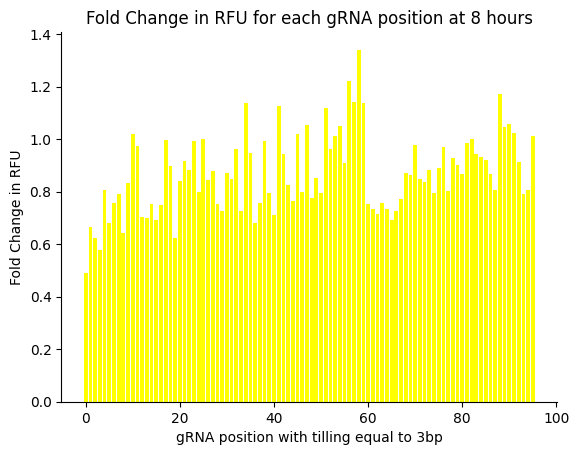

In [3]:
fig, ax = plt.subplots(1,1)
ax.bar(range(len(data)), data, color = 'yellow')
ax.set_xlabel("gRNA position with tilling equal to 3bp")
ax.set_ylabel('Fold Change in RFU')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Fold Change in RFU for each gRNA position at 8 hours")
if True:
    plt.savefig("./Figures/foldchange.png")

### Define the gRNA2knockdown model parameters.
- The size of the gRNAs is 30 bp, so it makes may make sense to make the intermediate layers 30 nodes.
- For now lets keep the embedding space the same size, and not try to use the resnet functionality.

In [4]:
stride_parameter = 25 #
label_dim = 1
embedding_dim = 8
intermediate_dim = 40 # Make this larger than the sequencing space
batch_size_parameter=5 # Should be the same as the number of gRNAs
debug_splash = 0
this_step_size_val = 10
this_corpus, this_labels = g2k.make_labeled_corpus(allseqs, data, stride_parameter)
sess = None

In [5]:
# Define the random transformation householder matrix.
Rand_Transform = g2k.rvs(dim=stride_parameter)

# Define the corpus for the model.
this_corpus_vec = []
for this_corpus_elem in this_corpus:
    vec_value = g2k.sequence_encoding(this_corpus_elem)
    vec_value = np.dot(Rand_Transform,vec_value)
    this_corpus_vec.append(vec_value)

this_corpus_vec = np.asarray(this_corpus_vec)
this_labels = np.expand_dims(this_labels,axis=1)
hidden_vars_list = [stride_parameter, embedding_dim, stride_parameter]
print(hidden_vars_list)

[25, 8, 25]


In [6]:
2784/96

29.0

### Build the model.

In [7]:
# Define the tensorflow session
if sess != None:
        sess.close()
sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution() # needed because of placeholder variables

this_u = tf.compat.v1.placeholder(tf.float32, 
                                    shape=[None,stride_parameter])

with tf.device('/cpu:0'):
    this_W_list,this_b_list = g2k.initialize_Wblist(stride_parameter,
                                                hidden_vars_list)
    this_y_out,all_layers = g2k.network_assemble(this_u,this_W_list,this_b_list
                                            ,keep_prob=1.0,
                                            activation_flag=2,res_net=0)

this_embedding = all_layers[-2]
regress_list = [intermediate_dim]*7+[label_dim]
with tf.device('/cpu:0'):
    this_Wregress_list,this_bregress_list = g2k.initialize_Wblist(embedding_dim,regress_list)


Length of hv_list: 3
shape: 
shape: 
shape: 
n_depth: 3
Length of hv_list: 8
shape: 
shape: 
shape: 
shape: 
shape: 
shape: 
shape: 
shape: 


In [8]:

HybridLoss = g2k.customLoss(this_y_out,this_u,this_embedding)
this_optim = tf.compat.v1.train.AdagradOptimizer(
    learning_rate=this_step_size_val).minimize(HybridLoss)
step_size = tf.compat.v1.placeholder(tf.float32,shape=[])
result = sess.run(tf.compat.v1.global_variables_initializer())
this_vae_loss = g2k.vae_loss(this_y_out,this_u)
this_embed_loss = g2k.embed_loss(this_u,this_embedding)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2024-03-12 11:07:19.980717: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


In [9]:
g2k.train_net(sess, this_corpus_vec, 
              this_u, HybridLoss,
              this_optim,
              batchsize=batch_size_parameter, 
              this_vae_loss=this_vae_loss, 
              this_embed_loss=this_embed_loss,
              step_size_val=this_step_size_val*0.1, 
              valid_error_thres=1e-4,
              test_error_thres=1e-4, max_iters=10e4,
              save_fig='Figures/stepsize0_05.png'
              )

 step 1 , validation error 2190.23
 step 1 , test error 2136.98
 Reconstruction Loss: 258.45636
 Embedding Loss: 2032.9553
 step 10 , validation error 41.6225
 step 10 , test error 39.9133
 Reconstruction Loss: 44.4535
 Embedding Loss: 0.30694872
 step 20 , validation error 18.032
 step 20 , test error 17.362
 Reconstruction Loss: 19.014017
 Embedding Loss: 0.30694872
 step 30 , validation error 1.84163
 step 30 , test error 1.86811
 Reconstruction Loss: 1.5493897
 Embedding Loss: 0.30694872
 step 40 , validation error 1.53609
 step 40 , test error 1.44745
 Reconstruction Loss: 1.1708443
 Embedding Loss: 0.30694872
 step 50 , validation error 1.20063
 step 50 , test error 1.13781
 Reconstruction Loss: 0.8076457
 Embedding Loss: 0.30694872
 step 60 , validation error 0.772133
 step 60 , test error 0.808539
 Reconstruction Loss: 0.37056962
 Embedding Loss: 0.30694872
 step 70 , validation error 1.07756
 step 70 , test error 1.00405
 Reconstruction Loss: 0.6602981
 Embedding Loss: 0.30694

([[0.54352903,
   0.6071019,
   0.51699513,
   0.47690725,
   0.5488614,
   0.6069098,
   0.5471501,
   0.51571727,
   0.53916955,
   0.5080819,
   0.54391396,
   0.5803423,
   0.5777538,
   0.60762453,
   0.5143643,
   0.54886997,
   0.5272733,
   0.60020983,
   0.5358507,
   0.5167852],
  [0.7070733,
   0.67981017,
   0.6613433,
   0.63753444,
   0.6465287,
   0.63613135,
   0.6384404,
   0.6465839,
   0.636878,
   0.66254807,
   0.6428733,
   0.6361127,
   0.6400175,
   0.6381426,
   0.6356356,
   0.63658214,
   0.64596856,
   0.6360277,
   0.6500157,
   0.65198153],
  [0.71932775,
   0.6958494,
   0.7292291,
   0.7228796,
   0.6808238,
   0.68521345,
   0.6807461,
   0.76376677,
   0.69306564,
   0.7163116,
   0.7147565,
   0.70161927,
   0.72293895,
   0.69667387,
   0.6709434,
   0.7164072,
   0.68640983,
   0.68057734,
   0.7018115,
   0.71649635]],
 1)

In [10]:
print(this_y_out.eval(feed_dict={this_u:[this_corpus_vec[2]]}, session=sess))
z_ind = this_y_out.eval(feed_dict={this_u:[this_corpus_vec[2]]}, session=sess)
print(this_corpus_vec)
print(this_corpus)

[[ 0.5062599   0.1433487  -0.755291    0.70801926 -0.79771423 -0.24669266
   1.1446495   0.30871964  0.8990364   0.44620895  0.4373436  -1.65551
  -0.324955    0.59820557  0.11753845  1.1208878  -0.5222626  -0.28328705
  -0.66457367 -0.10960007 -0.38256836 -0.4348526  -0.32425308 -0.48883057
   0.802578  ]]
[[ 0.52609877  0.80721514 -0.75500768 ... -0.29846318 -0.47350671
   0.45488936]
 [ 0.58968444  0.46191493 -1.45212097 ... -0.02693954 -0.15627234
   0.64853392]
 [ 1.15227639  0.28076043 -1.39392684 ... -0.07647717 -0.38354451
   0.72050744]
 ...
 [ 1.32150951  0.51203166 -1.12935242 ... -0.66217759 -0.3493105
   0.62261783]
 [ 1.06991382  0.53779636 -0.62572961 ... -0.14507897 -0.2929042
   1.45396008]
 [ 0.45542402  0.35182197 -0.70844273 ... -0.33765923 -0.10914422
   1.65527377]]
['TTGATCTCCTTTTTAAGTGAACTTG', 'TGATCTCCTTTTTAAGTGAACTTGG', 'GATCTCCTTTTTAAGTGAACTTGGG', 'ATCTCCTTTTTAAGTGAACTTGGGC', 'TCTCCTTTTTAAGTGAACTTGGGCC', 'CTCCTTTTTAAGTGAACTTGGGCCC', 'TTTCATTGTTGATCTCCTTTTTAAG

['T', 'T', 'T', 'T', 'T', 'C', 'T', 'C', 'T', 'T', 'C', 'C', 'T', 'T', 'T', 'C', 'C', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'C', 'T', 'T', 'C', 'C', 'T', 'T', 'T', 'C', 'C', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'C', 'T', 'T', 'C', 'C', 'T', 'T', 'T', 'C', 'C', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'C', 'T', 'T', 'C', 'C', 'T', 'T', 'T', 'C', 'C', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'C', 'T', 'T', 'C', 'C', 'T', 'T', 'T', 'C', 'C', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'C', 'T', 'T', 'C', 'C', 'T', 'T', 'T', 'C', 'C', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'C', 'T', 'T', 'C', 'C', 'T', 'T', 'T', 'C', 'C', 'C', 'C', 'T', 'G', 'C', 'T', 'T', 'T']
['T', 'T', 'T', 'T', 'T', 'C', 'T', 'C', 'T', 'T', 'C', 'C', 'T', 'T', 'T', 'C', 'C', 'C', 'C', 'T', 'G', 'C', 'T', 'T

0.0

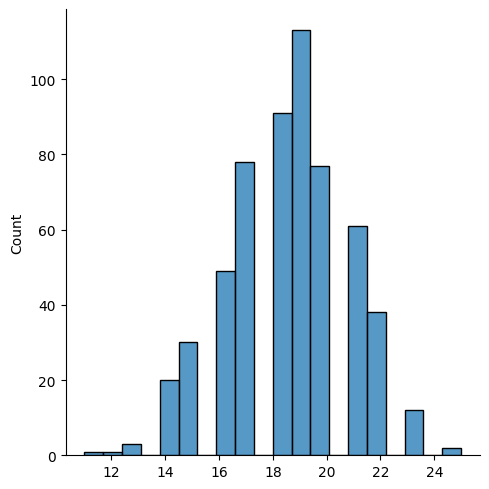

In [11]:
import seaborn as sns;
all_mismatches = []
for ind in range(0,len(this_corpus_vec)):
    z_ind = this_y_out.eval(feed_dict={this_u:[this_corpus_vec[ind]]}, session=sess)
    this_seq_out = g2k.vecback2seq(np.dot(np.linalg.inv(Rand_Transform),z_ind.T))
    print(g2k.vecback2seq(np.dot(np.linalg.inv(Rand_Transform),z_ind.T)))
    this_seq_out = ''.join(this_seq_out)
    all_mismatches.append(g2k.num_mismatch(this_seq_out,this_corpus[ind]));
hist_data = sns.displot(all_mismatches)
mismatch_process = np.array(all_mismatches);
mismatch_process[mismatch_process<=2.0] = 1.0;
mismatch_process[mismatch_process>2.0] = 0.0;
np.sum(mismatch_process)/(len(mismatch_process)*1.0)

# Hyperparameter Sweeping
Try to sweep various hyperparameters to find an optimal model parameter.